In [1]:
from evalutils import *
from lccv import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import ast
import os
from io import StringIO
import gzip

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

# Result Query
```sql
SELECT total, open, CONCAT(ROUND(100 * open / total, 2), "%") as "open (rel)", running, CONCAT(ROUND(100 * running / total, 2), "%") as "running (rel)", finished, CONCAT(ROUND(100 * finished / total, 2), "%") as "finished (rel)", successful, failed, CONCAT(ROUND(100 * successful / (successful + failed), 2), "%") as "success rate", CONCAT(ROUND(avgRuntimeFinished), "s") as "Average Time of Finished", CONCAT(ROUND(avgRuntimeFinished * open / running), "s") as "ETA" FROM (SELECT "aux" as pk, COUNT(*) as "open" FROM `lccollection` WHERE time_started is null) as t1 NATURAL JOIN (SELECT "aux" as pk, COUNT(*) as "running" FROM `lccollection` WHERE time_started is not null and time_end is null) as t2 NATURAL JOIN (SELECT "aux" as pk, COUNT(*) as finished, AVG(TIMESTAMPDIFF(SECOND, time_started, time_end)) as avgRuntimeFinished  FROM `lccollection` WHERE time_started is not null and time_end is not null) as t3 NATURAL JOIN (SELECT "aux" as pk, COUNT(*) as successful FROM `lccollection` where time_end is not null and exception is null) as t4 NATURAL JOIN (SELECT "aux" as pk, COUNT(*) as failed FROM `lccollection` where exception is not null) as t5 NATURAL JOIN (SELECT "aux" as pk, COUNT(*) as total FROM `lccollection`) as t6

```

In [2]:
with gzip.open('../results/lccollection.csv.tar.gz','r') as f:        
    df = pd.read_csv(f, delimiter=";")
    df[df["result"].notna()]

In [3]:
rows = []
n = len(df[df["result"].notna()])
pbar = tqdm(total=n)
for i, row in df[df["result"].notna()].iterrows():
    batch_results = ast.literal_eval(row["result"])
    for r in batch_results:
        rows.append([row["openmlid"], row["learner"], r["seed"], r["size_train"], 1 - r["accuracy_test"], int(np.round(r["traintime"]*1000))])

    pbar.update(1)
pbar.close()
dfResults = pd.DataFrame(rows, columns=["openmlid", "learner", "seed", "trainsize", "errorrate", "runtime"])
dfResults

  0%|          | 0/11011 [00:00<?, ?it/s]

,openmlid,learner,seed,trainsize,errorrate,runtime
0,1485.0,sklearn.svm.LinearSVC,0,16,0.5255,23
1,1485.0,sklearn.svm.LinearSVC,0,23,0.4870,26
2,1485.0,sklearn.svm.LinearSVC,0,32,0.4634,36
3,1485.0,sklearn.svm.LinearSVC,0,45,0.4724,50
4,1485.0,sklearn.svm.LinearSVC,0,64,0.4578,69
...,...,...,...,...,...,...
1677373,31.0,sklearn.ensemble.GradientBoostingClassifier,99,181,0.3272,111
1677374,31.0,sklearn.ensemble.GradientBoostingClassifier,99,256,0.2836,119
1677375,31.0,sklearn.ensemble.GradientBoostingClassifier,99,362,0.3135,128
1677376,31.0,sklearn.ensemble.GradientBoostingClassifier,99,512,0.2930,150


Creating 3 figures.
Found non-convexity for sklearn.discriminant_analysis.LinearDiscriminantAnalysis at size 513 (compared to 512). [-0.0, -0.02]
Found non-convexity for sklearn.discriminant_analysis.LinearDiscriminantAnalysis with slopes: [-0.0, -0.0, -0.0, -0.0, -0.0, -0.02]
Found non-convexity for sklearn.ensemble.ExtraTreesClassifier at size 513 (compared to 512). [-0.0, -0.02]
Found non-convexity for sklearn.ensemble.ExtraTreesClassifier with slopes: [-0.0, -0.0, -0.0, -0.0, -0.0, -0.02]
Found non-convexity for sklearn.ensemble.GradientBoostingClassifier at size 513 (compared to 512). [-0.0, -0.02]
Found non-convexity for sklearn.ensemble.GradientBoostingClassifier with slopes: [-0.0, -0.0, -0.0, -0.0, -0.0, -0.02]
Found non-convexity for sklearn.ensemble.RandomForestClassifier at size 513 (compared to 512). [-0.0, -0.01]
Found non-convexity for sklearn.ensemble.RandomForestClassifier with slopes: [-0.0, -0.0, -0.0, -0.0, -0.0, -0.01]
Found non-convexity for sklearn.linear_model.L

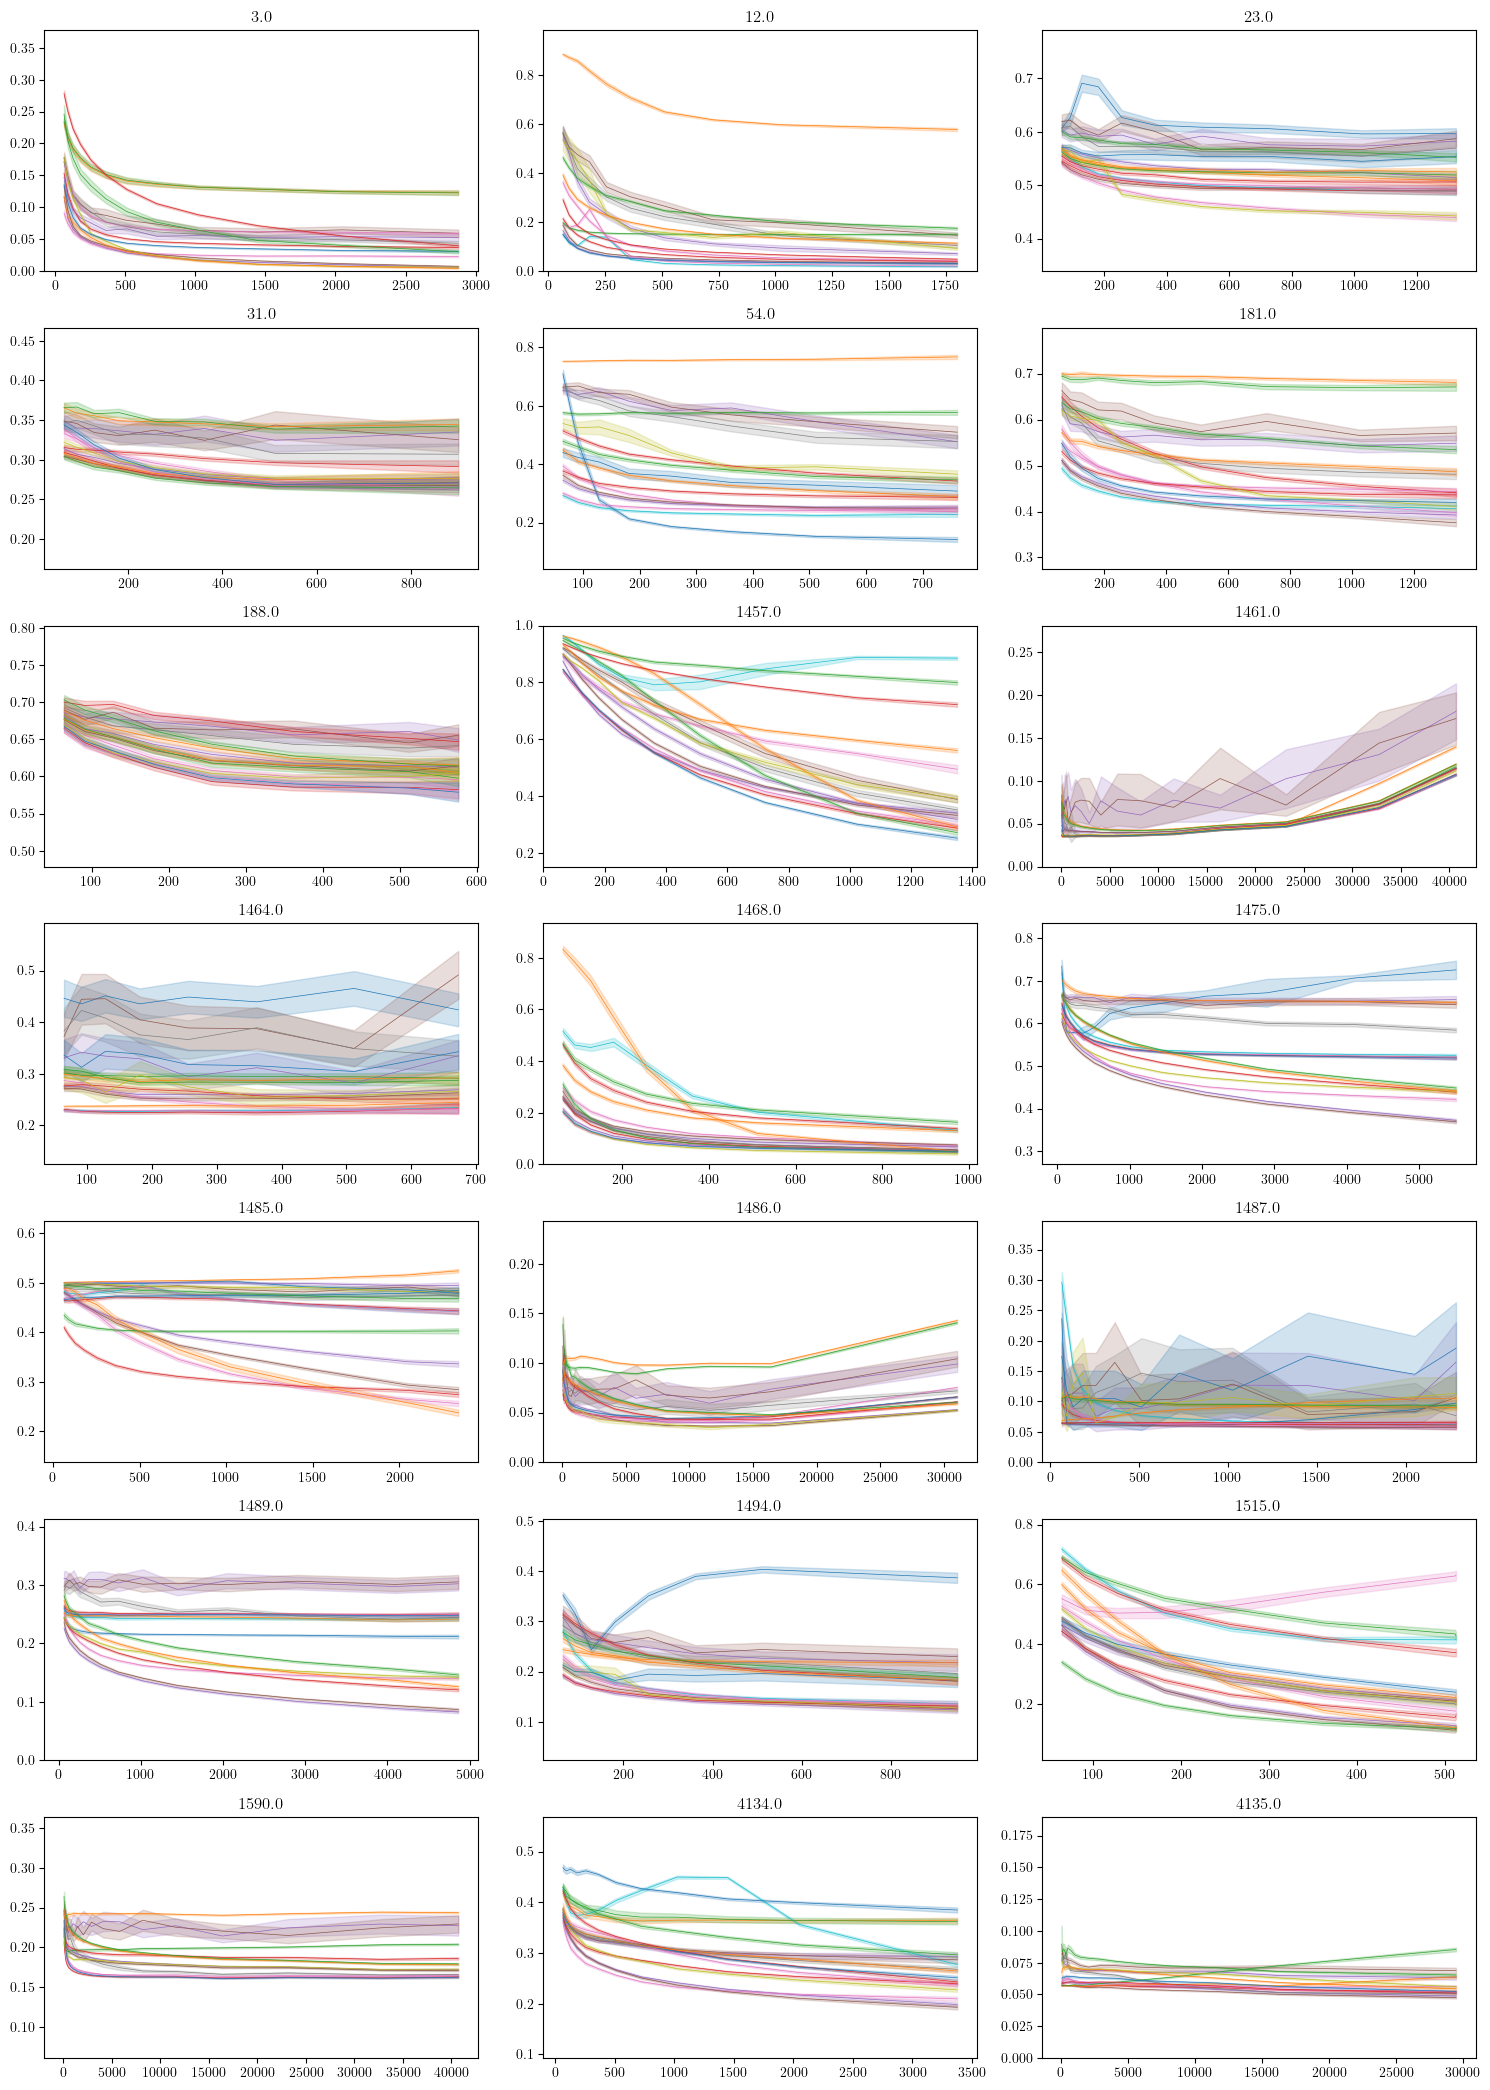

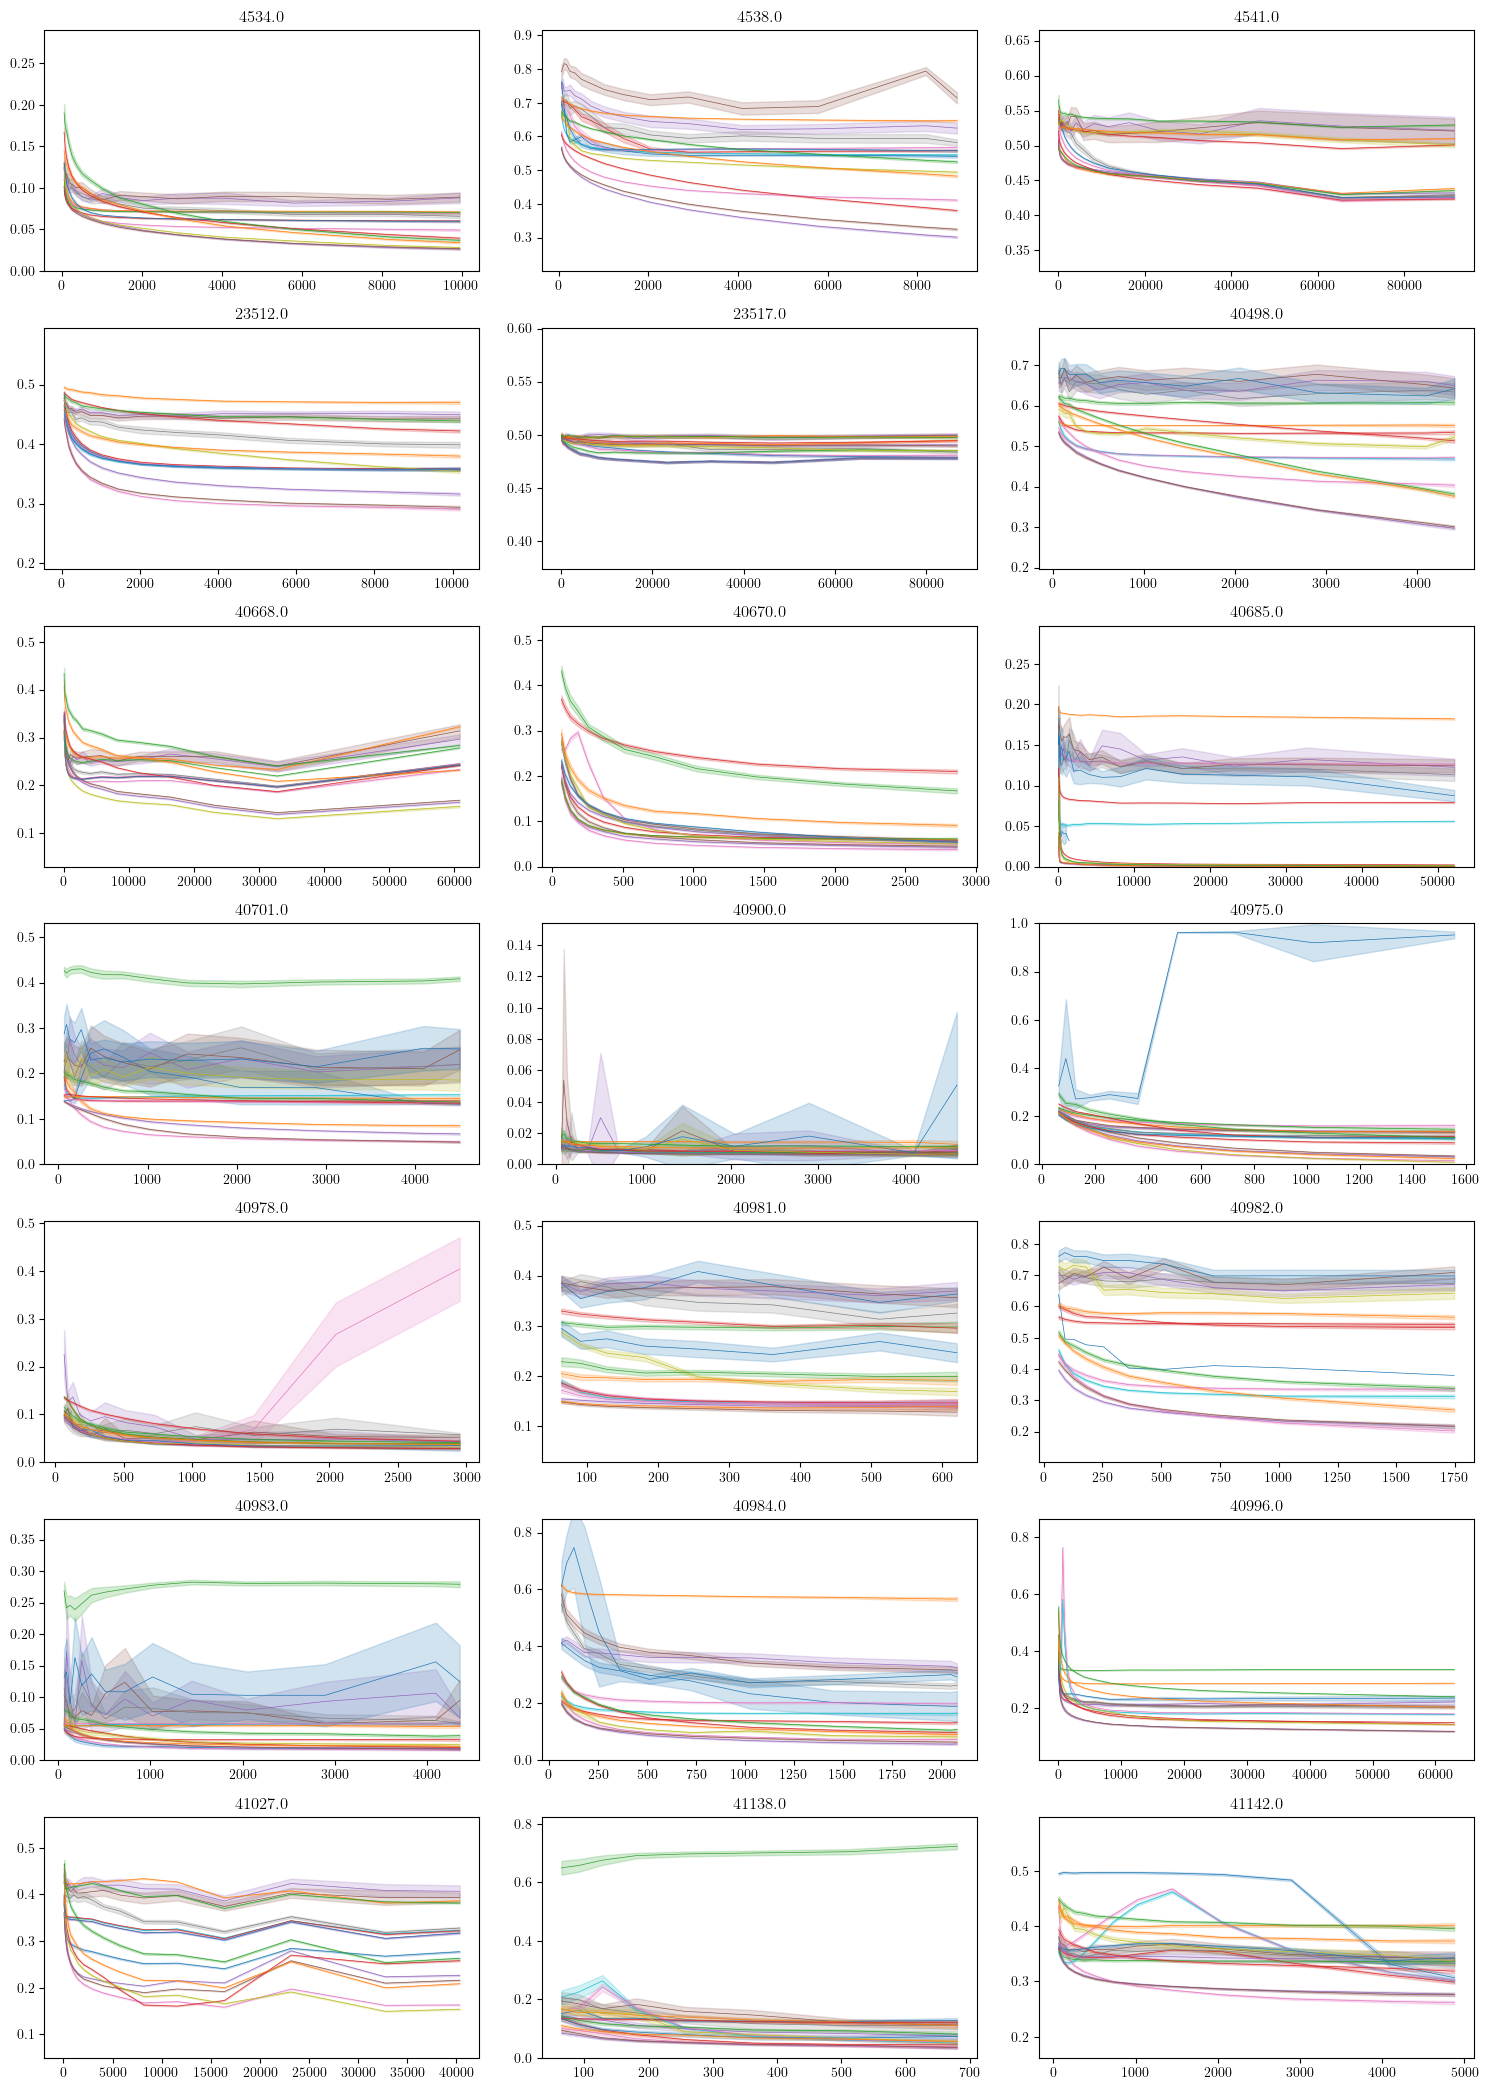

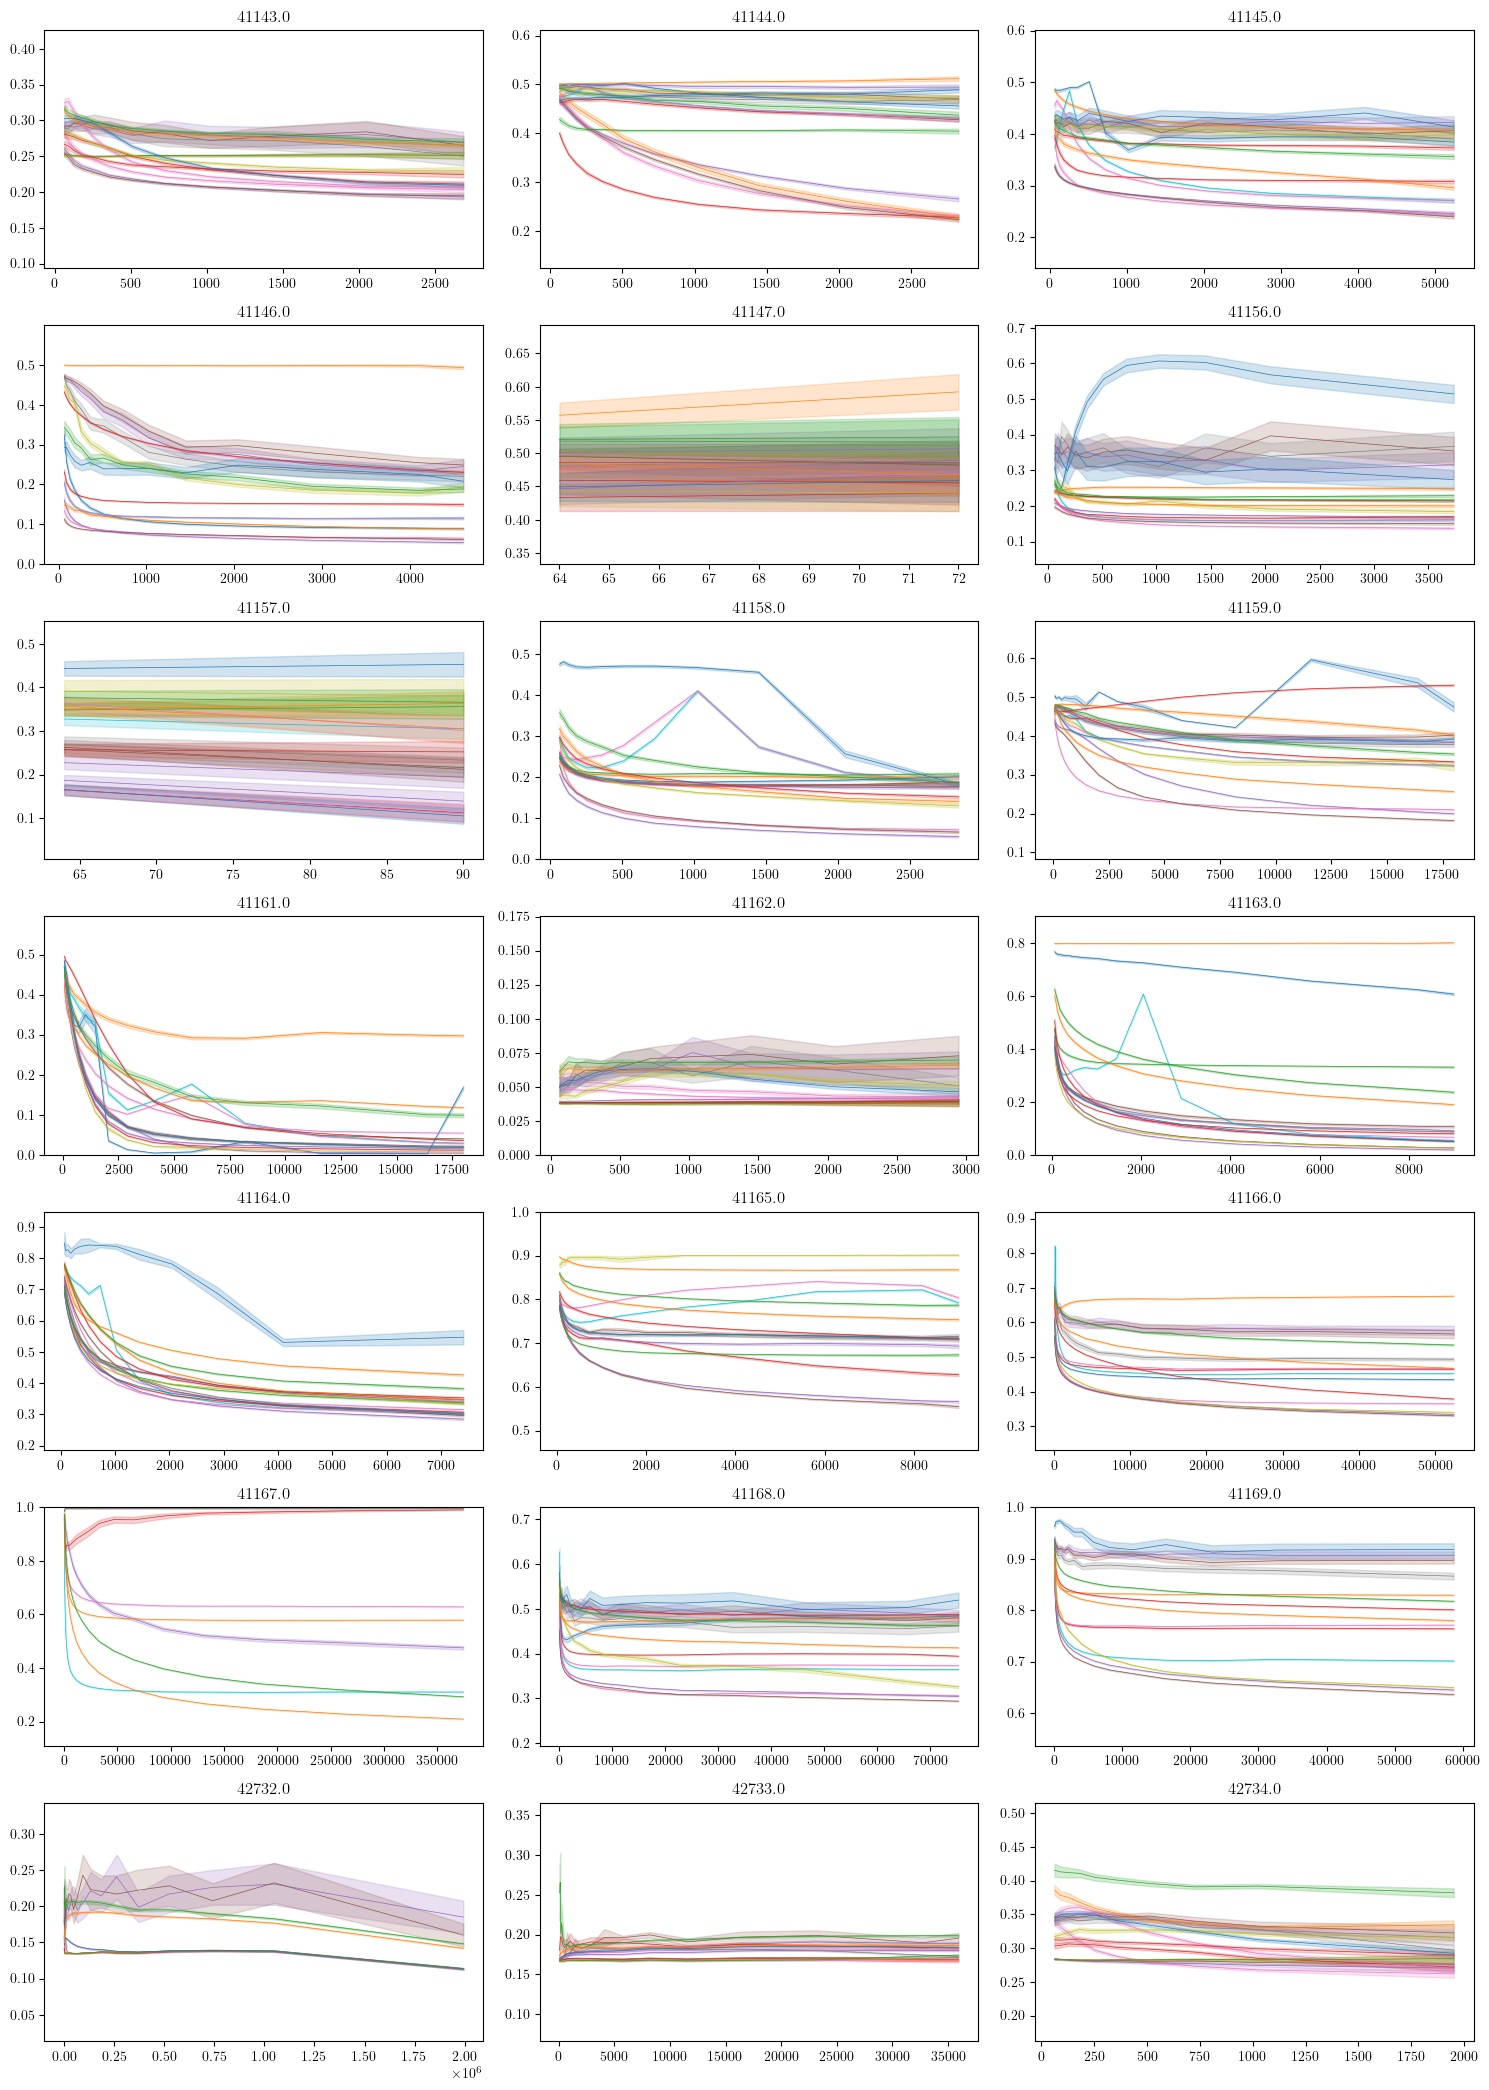

(0.983983983983984, 983, 999)

In [4]:
def plot_learning_curves(dfCache, cols=1, max_rows=10**66):
    
    algorithms = list(pd.unique(dfCache["learner"]))
    
    total_analyzed = 0
    total_convex = 0
    
    height_per_plot = 3
    datasets = pd.unique(dfCache["openmlid"])
    rows = int(np.ceil(len(datasets) / cols))
    
    num_figs = int(np.ceil(rows / max_rows))
        
    print(f"Creating {num_figs} figures.")
    
    fig_cnt = 1
    
    
    fig, ax_array = plt.subplots(min(rows, max_rows), cols, figsize=(15, min(rows, max_rows) * height_per_plot))
    row = 0
    col = 0
    for ds_idx, (openmlid, dfDataset) in enumerate(dfCache.groupby("openmlid")):
        ax = ax_array[row][col] if len(ax_array.shape) > 1 else ax_array[row]
        col += 1
        if col >= cols:
            col = 0
            row += 1
            
        max_val = 0
        min_val = 1

        for learner, dfLearner in dfDataset.groupby("learner"):

            is_convex = True
            sizes = [s for s in sorted(pd.unique(dfLearner["trainsize"])) if s >= 64]
            values = []
            conf = []
            optimistic_slopes = []
            for i, size in enumerate(sizes):

                values_at_size = dfLearner[dfLearner["trainsize"] == size]["errorrate"].values
                values.append(np.mean(values_at_size))
                max_val = max(max_val, np.mean(values_at_size))
                min_val = min(min_val, np.mean(values_at_size))
                mu = np.mean(values_at_size)
                sigma = np.std(values_at_size)
                conf_at_size = scipy.stats.norm.interval(0.95, loc=mu, scale=sigma/np.sqrt(len(values_at_size)))
                conf.append(conf_at_size)

                if size >= 128:
                    optimistic_slope = np.round((conf[i][0] - conf[i-1][1]) / (size - sizes[i-1]), 2)
                    optimistic_slopes.append(optimistic_slope)

                    if len(optimistic_slopes) >= 2 and optimistic_slope < optimistic_slopes[-2]:
                        print("Found non-convexity for " + str(learner) + " at size " + str(size) + " (compared to " + str(sizes[i - 1]) + "). " + str(optimistic_slopes[-2:]))
                        is_convex = False

            slope_orders = np.argsort(optimistic_slopes)
            
            if not is_convex:
                print("Found non-convexity for " + str(learner) + " with slopes: " + str(optimistic_slopes))
            else:
                total_convex += 1
            conf = np.array(conf)
            color = "C" + str(algorithms.index(learner))
            ax.plot(sizes, values, label=learner, color=color, linewidth=.5)
            if len(conf) > 0:
                ax.fill_between(sizes, conf[:,0], conf[:,1], alpha=0.2, color=color)

            total_analyzed += 1
        ax.set_title(openmlid)
        ax.set_ylim([max(0, min_val - 0.1), min(1, max_val + 0.1)])
        fig.tight_layout()
    
        if row >= max_rows:
            plt.show()
            fig.savefig(f"plots/learningcurves_{fig_cnt}.pdf")
            
            if ds_idx < len(datasets) - 1:
                fig, ax_array = plt.subplots(min(rows, max_rows), cols, figsize=(15, min(rows, max_rows) * height_per_plot))
                row = 0
                col = 0
                fig_cnt += 1
            else:
                fig = None
    
    if fig is not None:
        fig.savefig(f"plots/learningcurves_{fig_cnt}.pdf")
            
    return total_convex/total_analyzed, total_convex, total_analyzed

plot_learning_curves(dfResults, cols = 3, max_rows = 7)